In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# for sake of simplicity, we will just import everything from desc
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

print_backend_info()

DESC version=0.16.0+579.g9f5db9655.
Using JAX backend: jax version=0.7.2, jaxlib version=0.7.2, dtype=float64.
Using device: NVIDIA A100-PCIE-40GB (id=0), with 40.00 GB available memory.


In [4]:
# includes all particle tracing capabilities and particle initialization
from desc.particles import *
# includes different solvers, stepsize controller and bunch of other tools for ODE integration
from diffrax import *

# Alpha Particle Trajectory Optimization in DESC

In [5]:
from desc.objectives.objective_funs import _Objective
from desc.particles import _trace_particles


class DirectParticleTracing(_Objective):
    """Confinement metric for radial transport from direct tracing.

    Traces particles in flux coordinates within the equilibrium, and
    returns a confinement metric based off of the average deviation of
    the particle trajectory from its initial flux surface. The trajectories
    are traced and a line is fitted to the radial position vs time,
    and the slope of this line is used as the metric.

    Parameters
    ----------
    eq : Equilibrium
        Equilibrium that will be optimized to satisfy the Objective.
    iota_grid : Grid, optional
        Grid to evaluate rotational transform profile on.
        Defaults to ``LinearGrid(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid)``.
    particles : ParticleInitializer
        should initialize them in flux coordinates, same seed
        will be used each time.
    model : TrajectoryModel
        should be either Vacuum or SlowingDown

    """

    __doc__ = __doc__.rstrip() + collect_docs(
        target_default="``target=0``.", bounds_default="``target=0``."
    )
    _static_attrs = _Objective._static_attrs + [
        "_trace_particles",
        "_max_steps",
        "_stepsize_controller",
        "_adjoint",
        "_event",
        "_particle_chunk_size",
    ]

    _coordinates = "rtz"
    _units = "(dimensionless)"
    _print_value_fmt = "Particle Confinement error: "

    def __init__(
        self,
        eq,
        particles,
        model,
        solver=Tsit5(),  # on CPU, Tsit5(scan_kind="bounded") is recommended
        ts=jnp.arange(0, 1e-3, 100),
        stepsize_controller=None,
        adjoint=RecursiveCheckpointAdjoint(),
        max_steps=None,
        min_step_size=1e-8,
        particle_chunk_size=None,
        target=None,
        bounds=None,
        weight=1,
        normalize=False,
        normalize_target=False,
        loss_function=None,
        deriv_mode="auto",
        name="Particle Confinement",
        jac_chunk_size=None,
    ):
        if target is None and bounds is None:
            target = 0
        self._ts = jnp.asarray(ts)
        self._adjoint = adjoint
        if max_steps is None:
            max_steps = 1
            max_steps = int((ts[-1] - ts[0]) / min_step_size * max_steps)
        self._max_steps = max_steps
        self._min_step_size = min_step_size
        self._stepsize_controller = (
            stepsize_controller
            if stepsize_controller is not None
            else PIDController(
                rtol=1e-4,
                atol=1e-4,
                dtmin=min_step_size,
                pcoeff=0.3,
                icoeff=0.3,
                dcoeff=0,
            )
        )
        assert model.frame == "flux", "can only trace in flux coordinates"
        self._model = model
        self._particles = particles
        self._solver = solver
        self._particle_chunk_size = particle_chunk_size
        self._interpolator = FourierChebyshevField(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid)
        super().__init__(
            things=eq,
            target=target,
            bounds=bounds,
            weight=weight,
            normalize=normalize,
            normalize_target=normalize_target,
            loss_function=loss_function,
            deriv_mode=deriv_mode,
            name=name,
            jac_chunk_size=jac_chunk_size,
        )

    def build(self, use_jit=True, verbose=1):
        """Build constant arrays.

        Parameters
        ----------
        use_jit : bool, optional
            Whether to just-in-time compile the objective and derivatives.
        verbose : int, optional
            Level of output.

        """
        eq = self.things[0]
        self._x0, self._model_args = self._particles.init_particles(
            model=self._model, field=eq
        )

        # one metric per particle
        self._dim_f = self._x0.shape[0]
        # self._dim_f = 1

        # tracing uses carteasian coordinates internally, the termainating event
        # must look at rho values by conversion
        def default_event(t, y, args, **kwargs):
            i = jnp.sqrt(y[0] ** 2 + y[1] ** 2)
            return jnp.logical_or(i < 0.0, i > 1.0)

        self._event = Event(default_event)

        timer = Timer()
        if verbose > 0:
            print("Precomputing transforms")
        timer.start("Precomputing transforms")
        self._interpolator.build(eq)

        timer.stop("Precomputing transforms")
        if verbose > 1:
            timer.disp("Precomputing transforms")

        super().build(use_jit=use_jit, verbose=verbose)

    def compute(self, params, constants=None):
        """Compute particle tracing metric errors.

        Parameters
        ----------
        params : dict
            Dictionary of equilibrium degrees of freedom, eg Equilibrium.params_dict
        constants : dict
            Dictionary of constant data, eg transforms, profiles etc. Defaults to
            self.constants

        Returns
        -------
        f : ndarray
            Average deviation in rho from initial surface, for each particle.
        """
        eq = self.things[0]
        self._interpolator.fit(params, {"iota": eq.iota, "current": eq.current})
        rpz, _ = _trace_particles(
            field=self._interpolator,
            y0=self._x0,
            model=self._model,
            model_args=self._model_args,
            ts=self._ts,
            params=None,
            stepsize_controller=self._stepsize_controller,
            saveat=SaveAt(ts=self._ts),
            max_steps=self._max_steps,
            min_step_size=self._min_step_size,
            solver=self._solver,
            adjoint=self._adjoint,
            event=self._event,
            options={},
            chunk_size=self._particle_chunk_size,
            throw=False,
            return_aux=False,
        )

        # rpz is shape [N_particles, N_time, 3], take just index rho
        rhos = rpz[:, :, 0]
        rho0s = self._x0[:, 0]

        def fit_line(y):
            ts = self._ts
            # replace nans with zeros, since (0,0) is already the initial
            # point, this will not affect the fit
            y = jnp.where(jnp.isnan(y), 0.0, y)
            ts = jnp.where(jnp.isnan(y), 0.0, ts)
            coeffs = jnp.polyfit(ts, y, 1)
            return coeffs[0]

        slopes = vmap(fit_line)(rhos - rho0s[:, None]) * self._ts[-1]
        return slopes

In [6]:
name = "precise_QA"
try:
    # if the file exists, load it
    eq = desc.io.load(f"eqs/{name}_vacuum_scaled_solved.h5")
    eqi_scaled = eq.copy()
except:
    # else, create it from scratch
    eqi = get(name)
    eq = rescale(eq=eqi, L=("a", 1.7044), B=("<B>", 5.86), copy=True)
    eq.pressure = 0
    eq.current = 0
    eq.solve(ftol=1e-4, verbose=1);
    eqi_scaled = eq.copy()
    eq.save(f"eqs/{name}_vacuum_scaled_solved.h5")

# The Vacuum Guiding Center model assumes a constant pressure profile and zero current
# If the equilibrium does not satisfy these conditions, raise an error.
if (eq.p_l[1:] != 0).any():
    raise ValueError("Equilibrium doesn't have constant pressure, please use a vacuum equilibrium.")
if (eq.c_l != 0).any():
    raise ValueError("Equilibrium has non-zero current, please use a vacuum equilibrium.")

In [7]:
# create N particles between rho=0.1 and rho=0.3 randomly
N = 10000  # number of particles traced
RHO0 = 0.1 + np.random.rand(N) * 0.2

model_flux = VacuumGuidingCenterTrajectory(frame="flux")
particles_flux = ManualParticleInitializerFlux(
    rho0=RHO0,
    theta0=np.random.rand(N) * 2 * np.pi,
    zeta0=np.random.rand(N) * 2 * np.pi,
    xi0=np.random.rand(N), # add negative region too
    E=3.5e6,
)

In [8]:
k = 1
print(f"=========== Optimizing with modes  > {k} ===========")
AR = eq.compute("R0/a")["R0/a"]
obj = ObjectiveFunction(
    [
        DirectParticleTracing(
            eq,
            particles=particles_flux,
            model=model_flux,
            solver=Tsit5(),
            ts=np.linspace(0, 1e-4, 300),
            min_step_size=1e-8,
            max_steps=1000,
            adjoint=ForwardMode(),  # default is RecursiveCheckpointAdjoint() (reverse mode)
            deriv_mode="fwd",
            # jac_chunk_size=1,
        ),
        AspectRatio(eq, target=AR, weight=1),  # keep aspect ratio similar
        # Elongation(eq=eq, bounds=(0, 3), weight=1),
    ]
)
if eq.iota is not None:
    constraints = (ForceBalance(eq), FixPressure(eq), FixPsi(eq), FixIota(eq))
else:
    constraints = (ForceBalance(eq), FixPressure(eq), FixPsi(eq), FixCurrent(eq))
R_modes = np.vstack(
    (
        [0, 0, 0],
        eq.surface.R_basis.modes[np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :],
    )
)
Z_modes = eq.surface.Z_basis.modes[np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :]
bdry_constraints = (
    FixBoundaryR(eq=eq, modes=R_modes),
    FixBoundaryZ(eq=eq, modes=Z_modes),   
)

optimizer = Optimizer("proximal-lsq-exact")
# optimizer = Optimizer("proximal-sgd")
eq.optimize(
    optimizer=optimizer,
    objective=obj,
    constraints=constraints + bdry_constraints,
    verbose=3,
    maxiter=30,
    ftol=1e-3,
    gtol=1e-3,
    xtol=1e-10,
    options={
        "solve_options": {"verbose": 0}
    }
);

=========== Optimizing with modes  > 1 ===========
Building objective: Particle Confinement
Precomputing transforms
Timer: Precomputing transforms = 2.97 sec
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 51.8 ms
Timer: Objective build = 10.9 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 2.48 sec
Timer: Objective build = 3.23 sec
Timer: Objective build = 2.96 ms
Timer: Eq Update LinearConstraintProjection build = 6.46 sec
Timer: Proximal projection build = 43.9 sec
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: fixed current
Building objective: lcfs R
Building objective: lcfs Z
Timer: Objective build = 1.13 sec
Timer: LinearConstraintProjection build = 2.35 sec
Number of parameters: 8
Number of objectives: 10001
Timer: Initializing the optimization = 47.6 sec

Starting optimization
Using method: proximal-lsq-exact
Solver options:
------------------------------------

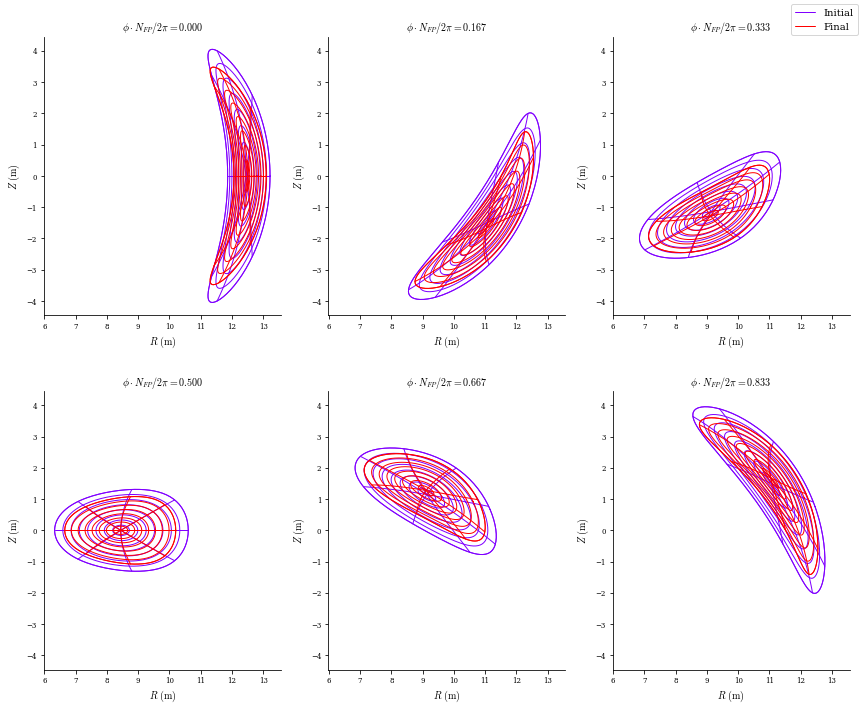

In [9]:
plot_comparison([eqi_scaled, eq], labels=["Initial", "Final"]);

In [10]:
# here we will plot the trajectories of optimized and initial equilibria
# we must use the same particles onject, because they are randomly initialized
# so, re-initializing them will give different particles

# 3D plots with many particles might not be visually useful!
ts = np.linspace(0, 1e-3, 1000)
dt = 1e-8
fig = plot_3d(eq, "|B|", alpha=0.3)
fig, data1 = plot_particle_trajectories(
    eq,
    model_flux,
    particles_flux,
    ts,
    fig=fig,
    min_step_size=dt,
    return_data=True,
)
fig2 = plot_3d(eqi_scaled, "|B|", alpha=0.3)
fig2, data2 = plot_particle_trajectories(
    eqi_scaled,
    model_flux,
    particles_flux,
    ts,
    fig=fig2,
    min_step_size=dt,
    color="red",
    return_data=True,
)

/home/ye2698/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)
/home/ye2698/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)
/home/ye2698/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.

/home/ye2698/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



In [ ]:
eq.save(f"{name}_optimized_1000particles_1e-4_1ar+1linefit+1elongation0-3.h5")

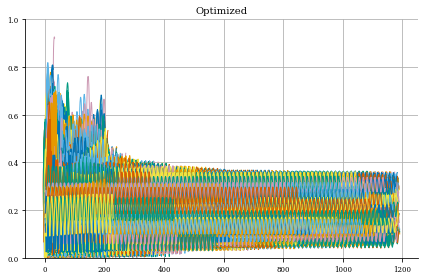

In [11]:
for i, (rhos, phis) in enumerate(zip(data1["rho"], data1["phi"])):
    plt.plot(phis, rhos)
plt.ylim([0,1])
plt.grid()
plt.title("Optimized");

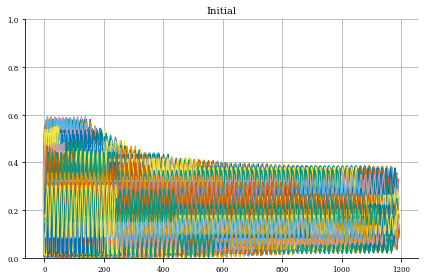

In [12]:
for i, (rhos, phis) in enumerate(zip(data2["rho"], data2["phi"])):
    plt.plot(phis, rhos)
plt.ylim([0, 1])
plt.grid()
plt.title("Initial");

Text(0.5, 1.0, 'Optimized')

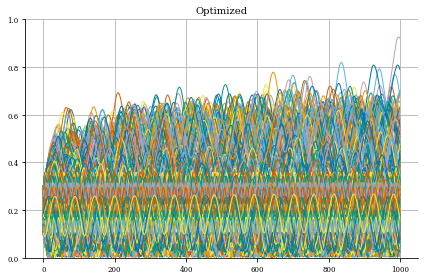

In [13]:
for rhos in data1["rho"]:
    plt.plot(rhos)
plt.ylim([0, 1])
plt.grid()
plt.title("Optimized")

Text(0.5, 1.0, 'Initial')

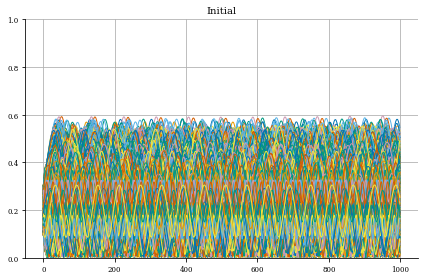

In [14]:
for rhos in data2["rho"]:
    plt.plot(rhos)
plt.ylim([0, 1])
plt.grid()
plt.title("Initial")

In [15]:
obj = ObjectiveFunction(
    DirectParticleTracing(
        eq,
        particles=particles_flux,
        model=model_flux,
        solver=Tsit5(),
        ts=np.linspace(0, 1e-4, 200),
        min_step_size=1e-8,
        max_steps=1000,
        adjoint=ForwardMode(),  # default is RecursiveCheckpointAdjoint() (reverse mode)
        deriv_mode="fwd",
    )
)
obj.build()

Building objective: Particle Confinement
Precomputing transforms


In [16]:
f0 = obj.compute_scaled_error(obj.x(eqi_scaled))
f1 = obj.compute_scaled_error(obj.x(eq))

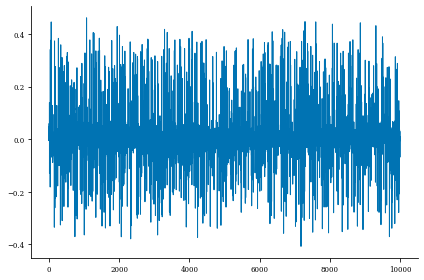

In [ ]:
plt.plot(f0)  # initial

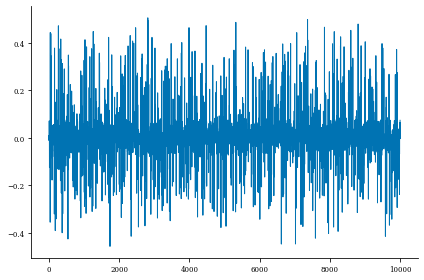

In [ ]:
plt.plot(f1)  # optimized

(<Figure size 432x432 with 2 Axes>,
 <Axes: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

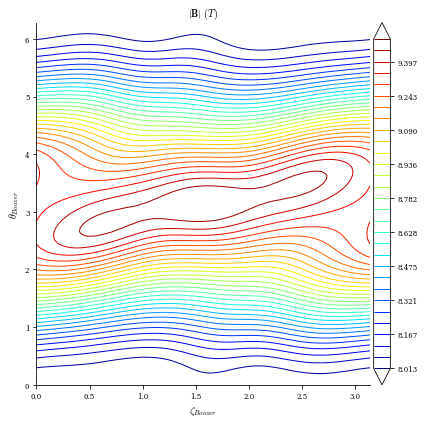

In [19]:
plot_boozer_surface(eq)

(<Figure size 432x432 with 2 Axes>,
 <Axes: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

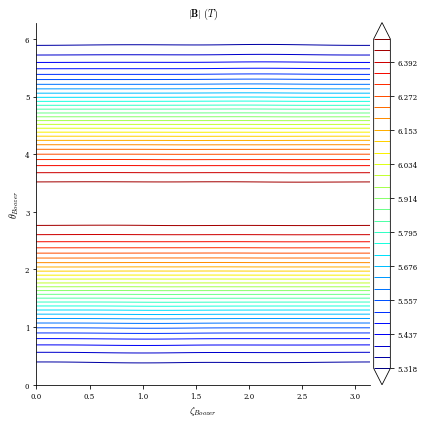

In [20]:
plot_boozer_surface(eqi_scaled)